# Machine Learning Contest
By: Kris Darnell & David Tang

01/30/17 Submission reverted to MLP classifier. 
Contest is described [here](https://github.com/seg/2016-ml-contest).

Split 0
    training:   [SHRIMPLIN, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY]
    validation: [ALEXANDER D, CHURCHMAN BIBLE]
Categories (2, object): [ALEXANDER D, CHURCHMAN BIBLE]
Split 1
    training:   [SHRIMPLIN, SHANKLE, LUKE G U, KIMZEY A, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, KIMZEY A, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
    validation: [ALEXANDER D, CROSS H CATTLE]
Categories (2, object): [ALEXANDER D, CROSS H CATTLE]
Split 2
    training:   [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
    validation: [ALEXANDER D, KIMZEY A]
Categories (2, object): [ALEXANDER D, KIMZEY A]
Split 3
    training:   [SHRIMPLIN, SHANKLE, LUKE G 

/home/u1/dgt377/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


F1 score = 0.481 {'sizes': (100, 100), 'alpha': 0.015, 'solver': 'sgd'}

Best F1 score = 0.481 {'sizes': (100, 100), 'alpha': 0.015, 'solver': 'sgd'}
well name is ALEXANDER D
[   0    1    2 ..., 4146 4147 4148]
[471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488
 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524
 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560
 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578
 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596
 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614
 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632
 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650
 651 652 653 654 655 656 657 658 659 660 661 662 663 664 6

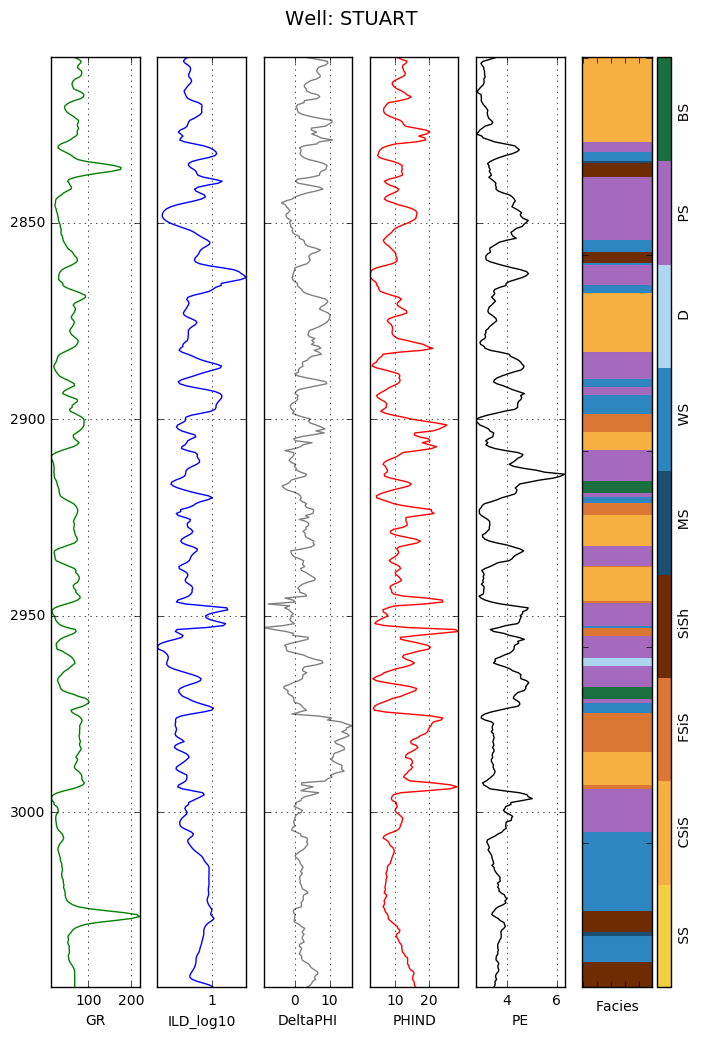

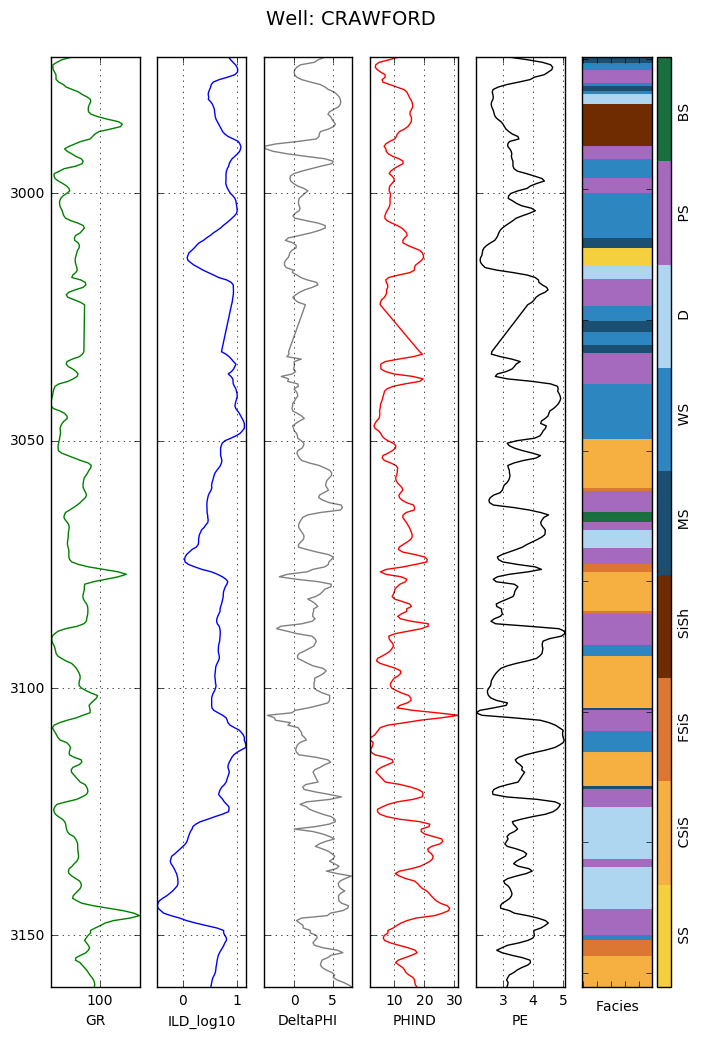

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 31 11:49:29 2017

@author: kdarnell
"""


# coding: utf-8

# # Machine Learning Contest
# By: Kris Darnell & David Tang
# 
# 01/30/17 Submission reverted to MLP classifier. 
# Contest is described [here](https://github.com/seg/2016-ml-contest).

# In[76]:

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier
from scipy.signal import medfilt

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

# Loading Data
filename = 'facies_vectors.csv'  # Read in training data
training_data = pd.read_csv(filename)
training_data.fillna(training_data.mean(),inplace=True)  # Remove NaNs
training_data
filename = 'validation_data_nofacies.csv'  # Read in test well
validationFull = pd.read_csv(filename)

# Converts to category
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()
training_data.describe()


# In[77]:

facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors

# Dictionary # enumerate puts out ind=0, label=SS, 
# and loops through the whole thing
facies_color_map = {}   
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
   
def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(
        lambda row: label_facies(row, facies_labels), axis=1)

correct_facies_labels = training_data['Facies'].values


dfs = []
for well in training_data['Well Name'].unique():
    df = training_data[training_data['Well Name']==well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE', 'GR', 'PHIND', 'ILD_log10', 'DeltaPHI']:
        # Rolling averages
        rollavg_col = 'rollavg_' + col
        df[rollavg_col] = df[col].rolling(window=10, center=False).mean()
        df[rollavg_col].fillna(method='ffill', inplace=True)
        df[rollavg_col].fillna(method='bfill', inplace=True)
        
        # Compute features gradient
        grad_col = 'grad_' + col
        df[grad_col] = df[col].diff()
        df[grad_col].fillna(method='ffill', inplace=True)
        df[grad_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
training_data = pd.concat(dfs)
PE_mean = training_data.PE.mean()
roll_PE_mean = training_data.rollavg_PE.mean()
training_data['PE'] = training_data.PE.replace({np.nan: PE_mean})
training_data['rollavg_PE'] = training_data['rollavg_PE'].replace(
        {np.nan: roll_PE_mean})
feature_vectors = training_data.drop(['Well Name', 'Facies',
                                      'FaciesLabels', 'Formation'], axis=1)
feature_vectors.describe()

dfs = []
for well in validationFull['Well Name'].unique():
    df = validationFull[validationFull['Well Name'] == well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE', 'GR', 'PHIND', 'ILD_log10', 'DeltaPHI']:
        rollavg_col = 'rollavg_' + col
        df[rollavg_col] = df[col].rolling(window=10, center=False).mean()
        df[rollavg_col].fillna(method='ffill', inplace=True)
        df[rollavg_col].fillna(method='bfill', inplace=True)
        
        # Compute features gradient
        grad_col = 'grad_' + col
        df[grad_col] = df[col].diff()
        df[grad_col].fillna(method='ffill', inplace=True)
        df[grad_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
validationFull = pd.concat(dfs)
validationFull.describe()
validation = validationFull.drop(['Formation', 'Well Name'], axis=1)

X = feature_vectors.values
y = correct_facies_labels
well = training_data['Well Name'].values
# ***
# Normalizing and splitting data


# In[79]:

#alpha_grid = [1e-3, 1e-2, 2e-2, 3e-2, 1e-1]  
#solver_grid = ['sgd', 'lbfgs']  
#sizes_grid = [(100, 100), (200, 200), (200, 200, 100)]

alpha_grid = [0.015]  
solver_grid = ['sgd']  
sizes_grid = [(100, 100)]
param_grid = []
for alpha in alpha_grid:
    for solver in solver_grid:
        for sizes in sizes_grid:
                        param_grid.append({'alpha': alpha, 
                                           'solver': solver, 
                                           'sizes':sizes})


# In[80]:
# Initialize model selection methods
from sklearn.model_selection import LeaveOneGroupOut, LeavePGroupsOut

lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=training_data['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_labels)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_labels)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
            
# Print splits
for s, split in enumerate(split_list):
    print('Split %d' % s)
    print('    training:   %s' % (training_data['Well Name'][split['train']].unique()))
    print('    validation: %s' % (training_data['Well Name'][split['val']].unique()))

# In[81]:   
def train_and_test(X_tr, y_tr, X_v, well_v, param):
    
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
#    scaler = preprocessing.StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
    
    # Train classifier  
    clf = MLPClassifier(solver=param['solver'], 
                        alpha=param['alpha'], 
                        hidden_layer_sizes=param['sizes'], 
                        random_state=seed)

    clf.fit(X_tr, y_tr)
    
    # Make prediction
    y_v_hat = clf.predict(X_v)
#    plt.plot(y_v_hat)
#    plt.title('Before')
#    plt.show()

    
    # Perform median filter to smooth results
    k_size = 5
    if len(np.unique(well_v)) > 1:
        for w in np.unique(well_v):
            y_v_hat[well_v == w] = medfilt(y_v_hat[well_v == w], kernel_size=k_size)
    else:
        y_v_hat = medfilt(y_v_hat, kernel_size=k_size)
#    plt.plot(y_v_hat)
#    plt.title('After')
#    plt.show()

    
    return y_v_hat
# In[82]:

# Do cross validation as an average across the leave p groups out splittin
seed = 200
np.random.seed(seed)

# For each set of parameters
score_param = []
for param in param_grid:
    
    # For each data split
    score_split = []
    for split in split_list:
    
        
        # Select training and validation data from current split
        X_tr = X[split['train'], :]
        X_v = X[split['val'], :]
        y_tr = y[split['train']]
        y_v = y[split['val']]
        
        # Select well labels for validation data
        well_v = well[split['val']]

        # Train and test
        y_v_hat = train_and_test(X_tr, y_tr, X_v, well_v, param)
        
        # Score
        score = f1_score(y_v, y_v_hat, average='micro')
        score_split.append(score)
        
    # Average score for this param
    score_param.append(np.mean(score_split))
    print('F1 score = %.3f %s' % (score_param[-1], param))
          
# Best set of parameters
best_idx = np.argmax(score_param)
param_best = param_grid[best_idx]
score_best = score_param[best_idx]
print('\nBest F1 score = %.3f %s' % (score_best, param_best))


# In[83]:
X_v = validation.values
well_v = validationFull['Well Name'].values
param = param_grid[best_idx]
validation_output = train_and_test(X, y, X_v, well_v, param)
validationFull['Facies'] = validation_output

# In[87]:
validationFull.to_csv('TangDarnell_sub6.csv')
# In[96]:
#

logo = LeaveOneGroupOut()        
all_scores = []
for train, test in logo.split(X, y, groups=well):
    well_name = well[test[0]]
    
    print('well name is', well_name)
    print(train)
    print(test)
    
    
    # Select training and validation data from current split
    X_tr = X[train,:]
    X_v = X[test,:]
    y_tr = y[train]
    y_v = y[test]
               
    # Train and test
    y_out= train_and_test(X_tr, y_tr, X_v, well_name, param)

    score = f1_score(y_out, y[test], average='micro')
    all_scores.append(score)
    print("{:>20s}  {:.3f}".format(well_name, score))
all_scores = np.asarray(all_scores)
print("Average F1 score is: {:.3f}".format(all_scores.mean()))


# In[ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
def make_facies_log_plot(logs, facies_colors):
   #make sure logs are sorted by depth
   logs = logs.sort_values(by='Depth')
   cmap_facies = colors.ListedColormap(
           facies_colors[0:len(facies_colors)], 'indexed')
   
   ztop=logs.Depth.min(); zbot=logs.Depth.max()
   
   cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1) # Makes it a nx1, repeating values along an dimension
   
   f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
   ax[0].plot(logs.GR, logs.Depth, '-g')
   ax[1].plot(logs.ILD_log10, logs.Depth, '-')
   ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
   ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
   ax[4].plot(logs.PE, logs.Depth, '-', color='black')
   im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                   cmap=cmap_facies,vmin=1,vmax=9)
   
   divider = make_axes_locatable(ax[5])
   cax = divider.append_axes("right", size="20%", pad=0.05)
   cbar=plt.colorbar(im, cax=cax)
   cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                               'SiSh', ' MS ', ' WS ', ' D  ', 
                               ' PS ', ' BS ']))
   cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
   
   for i in range(len(ax)-1):
       ax[i].set_ylim(ztop,zbot)
       ax[i].invert_yaxis()
       ax[i].grid()
       ax[i].locator_params(axis='x', nbins=3)
   
   ax[0].set_xlabel("GR")
   ax[0].set_xlim(logs.GR.min(),logs.GR.max())
   ax[1].set_xlabel("ILD_log10")
   ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
   ax[2].set_xlabel("DeltaPHI")
   ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
   ax[3].set_xlabel("PHIND")
   ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
   ax[4].set_xlabel("PE")
   ax[4].set_xlim(logs.PE.min(),logs.PE.max())
   ax[5].set_xlabel('Facies')
   
   ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
   ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
   ax[5].set_xticklabels([])
   f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)


# In[11]:

get_ipython().magic('matplotlib inline')
make_facies_log_plot(
    validationFull[validationFull['Well Name']=='STUART'],
    facies_colors=facies_colors)
make_facies_log_plot(
    validationFull[validationFull['Well Name']=='CRAWFORD'],
    facies_colors=facies_colors)



